## Import all the relevant packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

## Define the variational autoencoder 

We use a simple architecture defined by the input, hidden, and latent dimensions. The input dimension is just the dimentionality of the input data, the hidden dimension is the width of the encoding and decoding neural nets. The latent dimension is the dimension of the narrowest layer, i.e. the output dimension of the encoder and in the input dimension of the decoder. We also use dropout and batch normalization to improve gradiant stability and convergence. the activation function is the leaky ReLU, although, it may be a good idea to try others. 

For reference, see e.g. 

In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(VAE, self).__init__()
        
        self.activation = activation
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## This cell is a work in progress to set up a hyperparemeter grid search to find optimate architecture parameters. 

You dont need to/shouldn't run this cell

In [3]:
class VAEWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, dropout_rate=0.3, lr=1e-3, batch_size=128, epochs=50):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def fit(self, X, y=None):
        # Create VAE model
        self.model = VAE(self.input_dim, self.hidden_dim, self.latent_dim, self.dropout_rate).to(self.device)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

        # Create DataLoader
        dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X))
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # Training loop
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for batch_idx, (data,) in enumerate(dataloader):
                data = data.to(self.device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = self.model(data)
                loss = vae_loss(recon_batch, data, mu, logvar)
                loss.backward()
                train_loss += loss.item()
                optimizer.step()

            avg_loss = train_loss / len(dataloader.dataset)
            scheduler.step(avg_loss)

        return self

    def score(self, X, y=None):
        self.model.eval()
        dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X))
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        total_loss = 0
        with torch.no_grad():
            for (data,) in dataloader:
                data = data.to(self.device)
                recon_batch, mu, logvar = self.model(data)
                loss = vae_loss(recon_batch, data, mu, logvar)
                total_loss += loss.item()
        avg_loss = total_loss / len(dataloader.dataset)
        return -avg_loss  # Return negative loss as score (higher is better)


## Define hyperparameters, the dataloader, training & test sets, then set up the model with relevant satasets & training scheduler into GPU

In [3]:
# Hyperparameters
input_dim = 784  # 28x28 pixels
hidden_dim = 400
latent_dim = 50
lr = 5e-2
batch_size = 128
num_epochs = 150
patience = 4
dropout_rate = 0.3
activation = nn.LeakyReLU(0.1)

# MNIST Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split the dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model, optimizer, and scheduler
model = VAE(input_dim, hidden_dim, latent_dim, dropout_rate, activation=activation).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)


## This was just to see what the MNIST data looks like
'''
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()
'''
#

/home/carlos/Documents/Research/ML for DM models/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


"\n# get 25 sample training images for visualization\ndataiter = iter(train_loader)\nimage = next(dataiter)\n\nnum_samples = 25\nsample_images = [image[0][i,0] for i in range(num_samples)] \n\nfig = plt.figure(figsize=(5, 5))\ngrid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)\n\nfor ax, im in zip(grid, sample_images):\n    ax.imshow(im, cmap='gray')\n    ax.axis('off')\n\nplt.show()\n"

## Train the model and visualize the loss and learning rate

Train Epoch: 1 [0/48000 (0%)]	Loss: 574.564453
Train Epoch: 1 [12800/48000 (27%)]	Loss: 180.000488
Train Epoch: 1 [25600/48000 (53%)]	Loss: 176.493927
Train Epoch: 1 [38400/48000 (80%)]	Loss: 166.891937
====> Epoch: 1 Average training loss: 211.2457
====> Validation loss: 151.7896
New best model saved with validation loss: 151.7896
Train Epoch: 2 [0/48000 (0%)]	Loss: 162.987381
Train Epoch: 2 [12800/48000 (27%)]	Loss: 156.340347
Train Epoch: 2 [25600/48000 (53%)]	Loss: 159.733780
Train Epoch: 2 [38400/48000 (80%)]	Loss: 146.551392
====> Epoch: 2 Average training loss: 156.4049
====> Validation loss: 140.3824
New best model saved with validation loss: 140.3824
Train Epoch: 3 [0/48000 (0%)]	Loss: 143.422028
Train Epoch: 3 [12800/48000 (27%)]	Loss: 148.885681
Train Epoch: 3 [25600/48000 (53%)]	Loss: 155.297623
Train Epoch: 3 [38400/48000 (80%)]	Loss: 152.715057
====> Epoch: 3 Average training loss: 149.6562
====> Validation loss: 137.5256
New best model saved with validation loss: 137.525

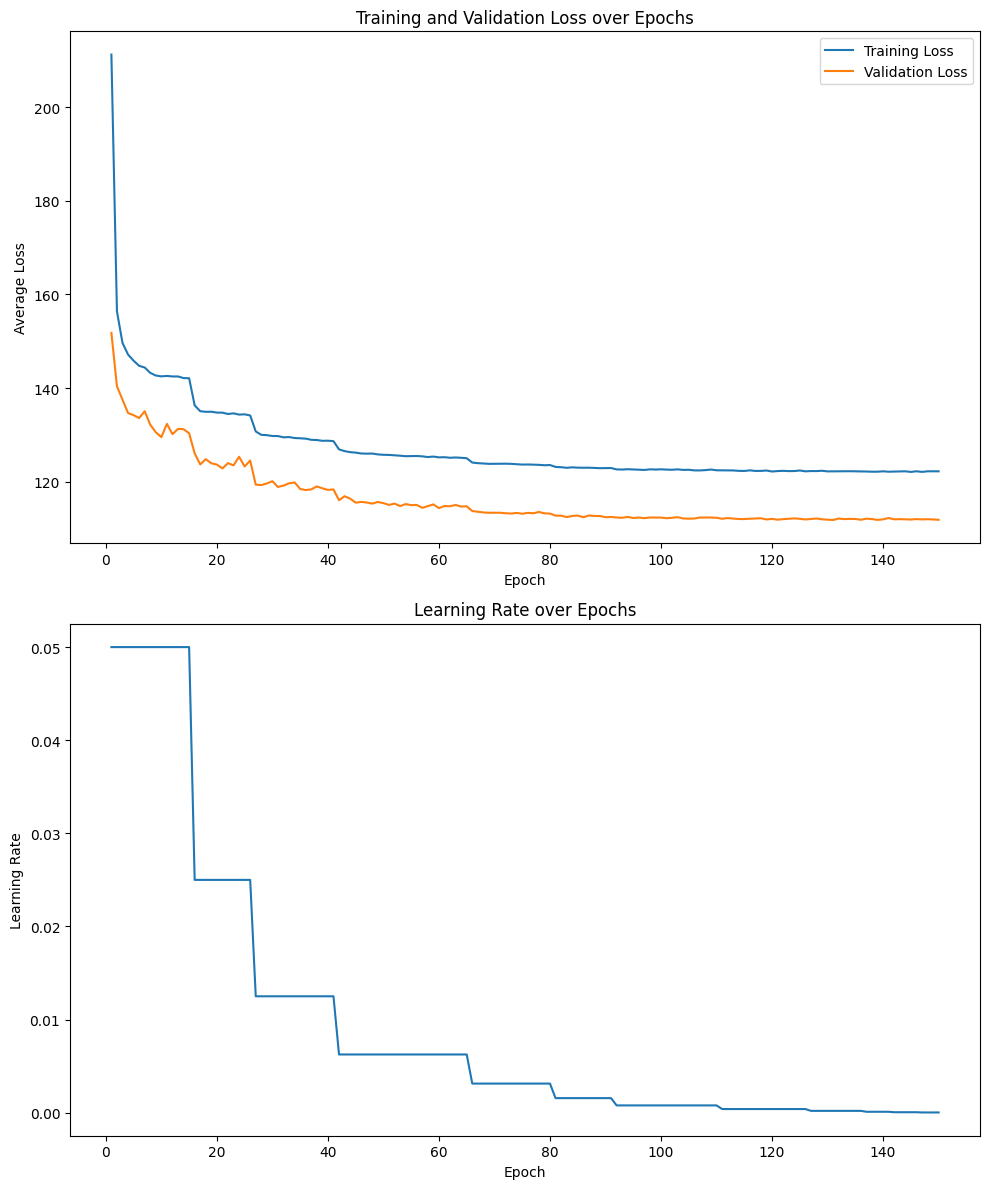

In [4]:
# Lists to store loss values and learning rates
train_losses = []
val_losses = []
learning_rates = []

# Training loop
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average training loss: {avg_loss:.4f}')
    return avg_loss

# Validation loop
def validate():
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.view(data.size(0), -1).to(device)
            recon_batch, mu, logvar = model(data)
            val_loss += vae_loss(recon_batch, data, mu, logvar).item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    print(f'====> Validation loss: {avg_loss:.4f}')
    return avg_loss

# Early stopping function
def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False

# Run training with early stopping and learning rate scheduling
best_loss = float('inf')
for epoch in range(1, num_epochs + 1):
    train_loss = train(epoch)
    val_loss = validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'vae_mnist_best.pth')
        print(f"New best model saved with validation loss: {best_loss:.4f}")
    
    if early_stopping(val_losses, patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

print("Training complete.")

# Plot the training and validation loss and learning rate
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot training and validation loss
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss')
ax1.legend()

# Plot learning rate
ax2.plot(range(1, len(learning_rates) + 1), learning_rates)
ax2.set_title('Learning Rate over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')

plt.tight_layout()
plt.show()

## Visualize the latent space representation of handwritten digits using PCA analysis.

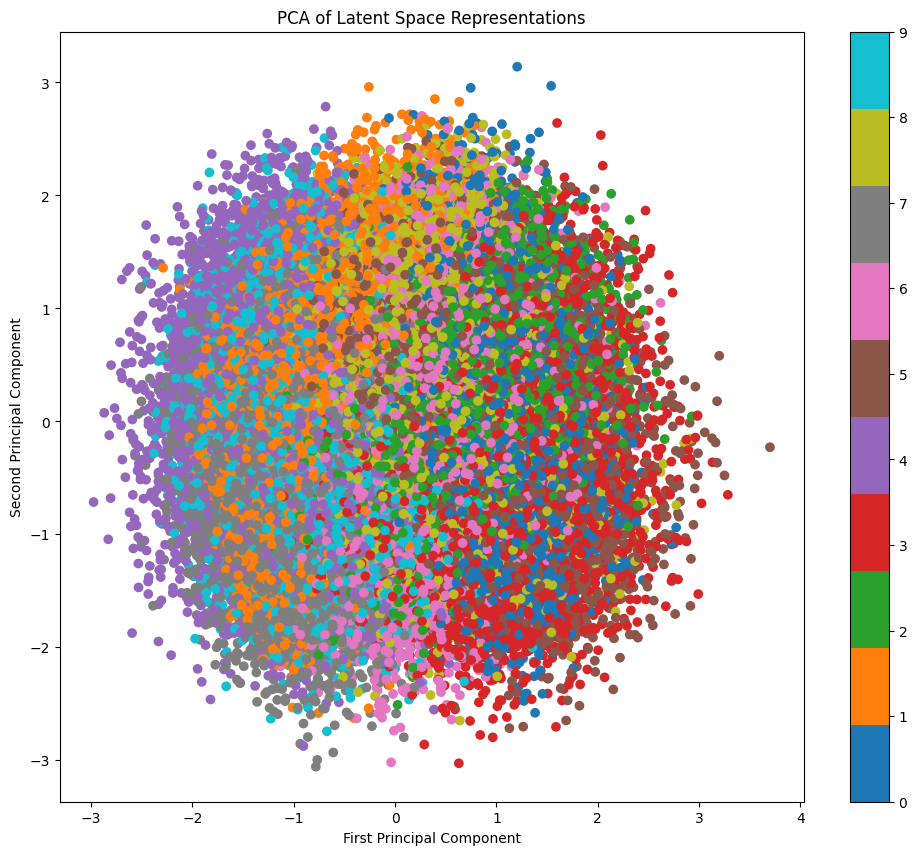

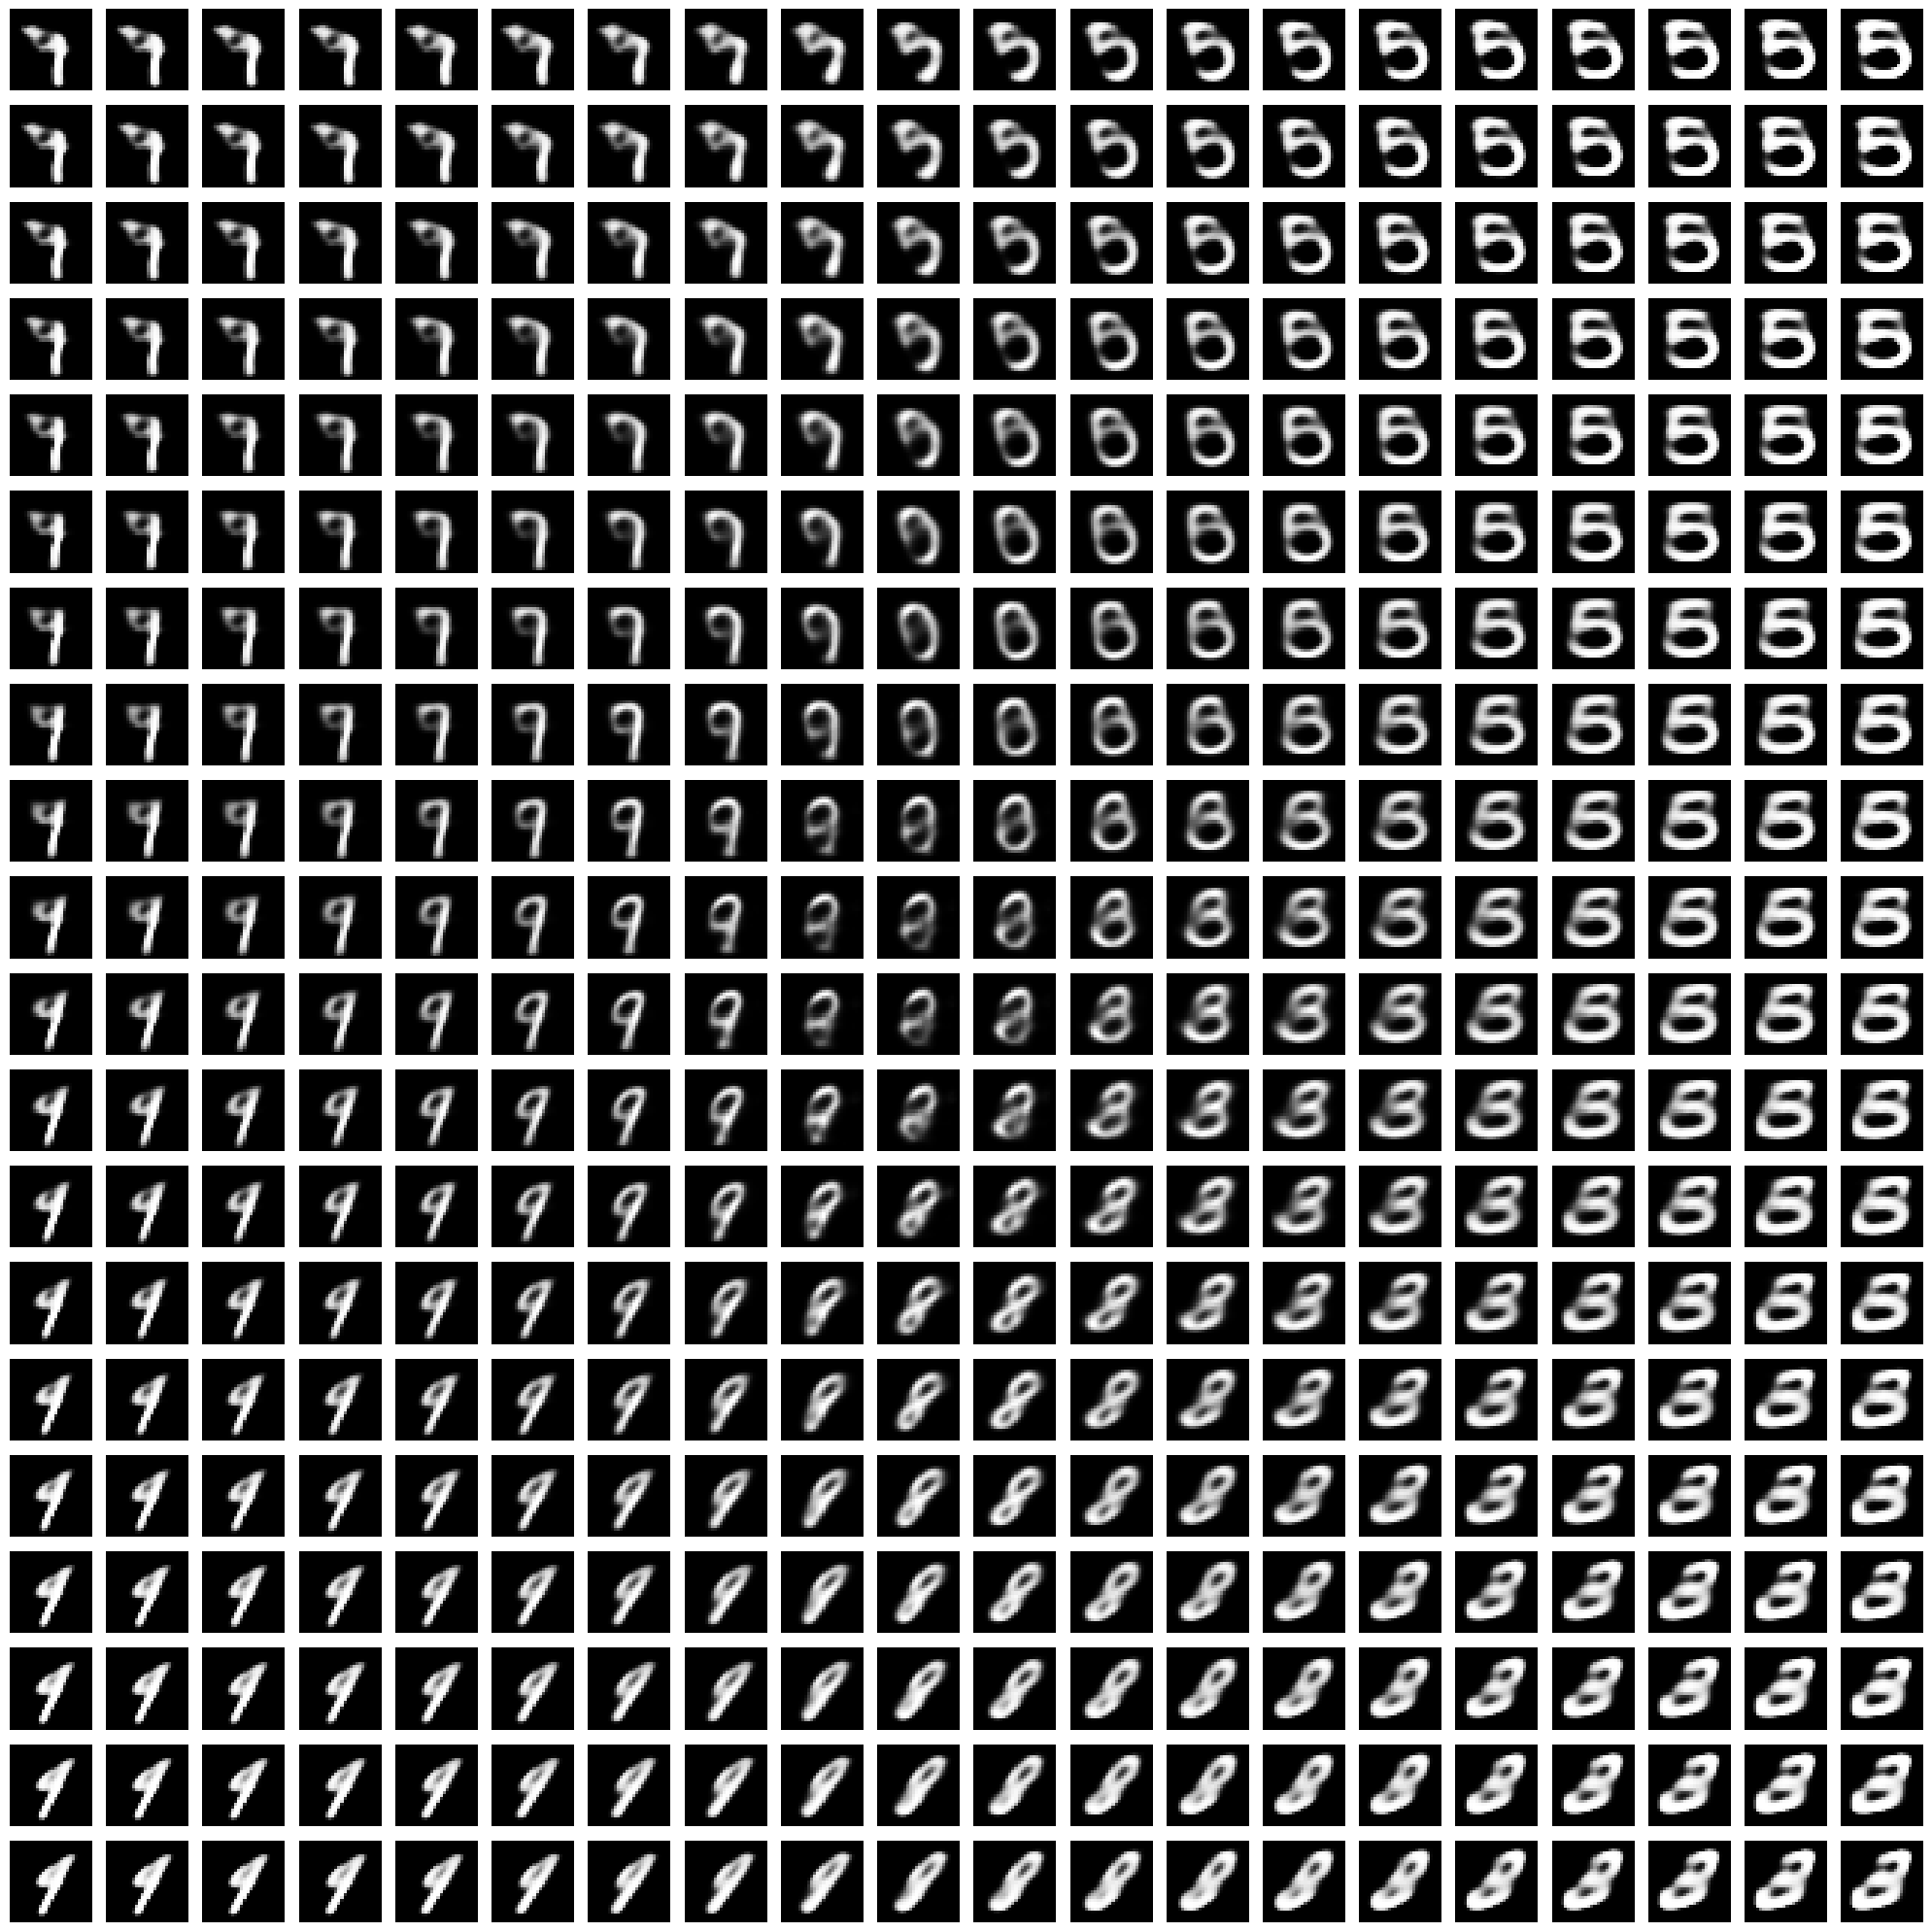

In [5]:
# Function to generate a number from a given point in latent space
def generate_number(model, latent_point, device):
    model.eval()
    with torch.no_grad():
        latent_point = torch.tensor(latent_point, dtype=torch.float32).unsqueeze(0).to(device)
        sample = model.decode(latent_point).cpu()
        img = sample.view(28, 28).numpy()
    return img

# Function to get latent space representations
def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    labels = []
    with torch.no_grad():
        for data, label in dataloader:
            data = data.view(data.size(0), -1).to(device)
            mu, _ = model.encode(data)
            latent_representations.append(mu.cpu().numpy())
            labels.append(label.numpy())
    return np.concatenate(latent_representations), np.concatenate(labels)

# Function to visualize the latent space after PCA
def visualize_latent_space_pca(latent_representations, labels, model, device):
    # Perform PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    # Plot the 2D latent space
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title('PCA of Latent Space Representations')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

    # Visualize generated numbers in the 2D latent space
    plt.figure(figsize=(20, 20))
    x_min, x_max = latent_2d[:, 0].min() - 1, latent_2d[:, 0].max() + 1
    y_min, y_max = latent_2d[:, 1].min() - 1, latent_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 20), np.linspace(y_min, y_max, 20))
    
    for i, (x, y) in enumerate(zip(xx.ravel(), yy.ravel())):
        latent_point = pca.inverse_transform([x, y])
        ax = plt.subplot(20, 20, i + 1)
        ax.imshow(generate_number(model, latent_point, device), cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load the trained model if you just want to continue where you left off
# model.load_state_dict(torch.load('vae_mnist.pth'))
# model.to(device)

# Get latent representations
latent_representations, labels = get_latent_representations(model, train_loader, device)

# Visualize the latent space after PCA
visualize_latent_space_pca(latent_representations, labels, model, device)